In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!pip install keras-tuner --upgrade

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv
/kaggle/input/playground-series-s3e2/sample_submission.csv
/kaggle/input/playground-series-s3e2/train.csv
/kaggle/input/playground-series-s3e2/test.csv


**Downloading data**
+ adding data from "stroke prediction dataset"

In [17]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e2/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e2/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e2/sample_submission.csv')
addition_data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

In [18]:
addition_data = addition_data[addition_data['stroke']==1]
addition_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
244,17739,Male,57.0,0,0,Yes,Private,Rural,84.96,36.7,Unknown,1
245,49669,Female,14.0,0,0,No,children,Rural,57.93,30.9,Unknown,1
246,27153,Female,75.0,0,0,Yes,Self-employed,Rural,78.80,29.3,formerly smoked,1
247,34060,Male,71.0,1,0,Yes,Self-employed,Rural,87.80,NaN,Unknown,1


In [19]:
from sklearn.neighbors import KNeighborsRegressor

def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

na_cols = [col for col in addition_data.columns if addition_data[col].isnull().sum()!=0]

for col in na_cols:  
    addition_data = knn_impute(addition_data, col)

In [20]:
# addition_data.bmi = addition_data.bmi.fillna(np.mean(addition_data.bmi))

In [21]:
# train_df['generated'] = 1
# test_df['generated'] = 1
# addition_data['generated'] = 0
train_df = pd.concat([train_df, addition_data],axis=0, ignore_index=True)

In [22]:
df = pd.concat([train_df, test_df], axis=0)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0.0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0.0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0.0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0.0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10199,25503,Female,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked,NaN
10200,25504,Male,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown,NaN
10201,25505,Female,3.0,0,0,No,children,Rural,104.04,18.3,Unknown,NaN
10202,25506,Male,31.0,0,0,Yes,Private,Urban,82.41,28.7,never smoked,NaN


Thanks to @edouardo for feature engineering ideas! https://www.kaggle.com/code/edouardo/my-stroke-of-insight#Feature-engineering
Please, upvote his notebook!

we will put 2 extra features with bmi: (from Brenden Siekman)

In [23]:
# df['morbid'] = np.where(df.bmi>40,1,0)
# df['obese'] = np.where(df.bmi>30,1,0)

from CRAIG THOMAS:

In [24]:
# def feature_risk_factors(df):
#     df["risk_factors"] = df[[
#         "avg_glucose_level", "age", "bmi", 
#         "hypertension", "heart_disease", 
#         "smoking_status"
#     ]].apply(
#         lambda x: \
#         0 + (1 if x.avg_glucose_level > 99 else 0) + \
#         (1 if x.age > 45 else 0) + (1 if x.bmi > 24.99 else 0) + \
#         (1 if x.hypertension == 1 else 0) + \
#         (1 if x.heart_disease == 1 else 0) + \
#         (1 if x.smoking_status in ["formerly smoked", "smokes"] else 0),
#         axis=1
#     )
#     return df

# feature_risk_factors(df)

In [25]:
df = pd.get_dummies(df)
df = df.drop('id', axis=1)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# num_cols = ['age', 'avg_glucose_level', 'bmi']

y = df['stroke']
df = df.drop('stroke', axis=1)

df[df.columns] = scaler.fit_transform(df[df.columns])

# df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [27]:
train_df = df.iloc[:-len(test_df),:]
train_df['stroke'] = y[:-len(test_df)]
test_df = df.iloc[-len(test_df):,:].reset_index(drop=True)

X = train_df.drop('stroke', axis=1)
y = train_df.stroke
X_test = test_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Keras model**
- Lots of graet ideas were taken from @kirillka95 notebook: https://www.kaggle.com/code/kirillka95/ps-s3e02-keras-nn-kfold-pub
Please upvote it!

In [28]:
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, Concatenate, Add, BatchNormalization, LeakyReLU

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

from sklearn.metrics import classification_report

# from imblearn.under_sampling import NearMiss
# from imblearn.keras import balanced_batch_generator

import keras_tuner

models = []
preds = []

# focal_loss = False
class_weight = 10 # 10 > 13

n_folds = 12 #11 < 12 > 13
repeats = 5  # 5
dr = 0.3     # 0.1 > 0.2

# k_fold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

def get_model():
    model = keras.Sequential([
#     layers.Dense(512), 
#     layers.LeakyReLU(alpha=0.3),
# #     layers.BatchNormalization(),
#     layers.Dropout(rate=dr),
    layers.Dense(256), 
    layers.LeakyReLU(alpha=0.3),
#     layers.BatchNormalization(),
    layers.Dropout(rate=dr),
    layers.Dense(128), 
    layers.LeakyReLU(alpha=0.3),
#     layers.BatchNormalization(),
    layers.Dropout(rate=dr),
    layers.Dense(64), 
    layers.LeakyReLU(alpha=0.3),
#     layers.BatchNormalization(),
    layers.Dropout(rate=dr),
    layers.Dense(32), 
    layers.LeakyReLU(alpha=0.3),
#     layers.BatchNormalization(),
    layers.Dropout(rate=dr),
    layers.Dense(16), 
    layers.LeakyReLU(alpha=0.3),
#     layers.BatchNormalization(),
    layers.Dropout(rate=dr),
    layers.Dense(8), 
#     layers.LeakyReLU(alpha=0.3),
    layers.BatchNormalization(),
    layers.Dropout(rate=dr),
    layers.Dense(4), 
#     layers.LeakyReLU(alpha=0.3),
    layers.BatchNormalization(),
#     layers.Dropout(rate=0.3),
    layers.Dense(2), 
    layers.LeakyReLU(alpha=0.3),
#     layers.BatchNormalization(),
#     layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid')
   ])

#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#                     initial_learning_rate=0.001,
#                     decay_steps=1000,
#                     decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=0.00005)
    
    model.compile(
    optimizer=opt,
    loss=tfa.losses.SigmoidFocalCrossEntropy(
#                                              alpha=hp.Choice('units', [0.6, 0.7, 0.8, 0.9]), 
                                             alpha=0.8,
                                             gamma=2.0
                                             ),   # alpha=0.80, gamma=2.0  > (0.7, 4.0)
    metrics='AUC',
)
    
    return model

early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_auc", 
        mode='max',
        patience=30,
        min_delta=0.00001,
        restore_best_weights=True,
)
plat = keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", 
        mode='max', 
        patience=3, 
        factor=0.1, 
        min_lr=1e-8, 
        min_delta=0.000001)

# tuner = keras_tuner.RandomSearch(
#     get_model,
#     objective='val_loss',
#     max_trials=5)

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
#     tuner.search(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
#     best_model = tuner.get_best_models()[0]
#     model = best_model
    
    model = get_model()
    
    
# #     training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, 
# #                                                                    sampler = NearMiss(), 
# #                                                                    batch_size = 10, 
# #                                                                    random_state = 42)
    
    history = model.fit(
#           training_generator, 
#           steps_per_epoch = steps_per_epoch,
          X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=64,
          epochs=500,
          class_weight = { 0: 1.0, 1: class_weight, },
          callbacks=[early_stopping, plat],
          verbose=1,
         )
    
    print(classification_report(y, np.round(model.predict(X))))
    models.append(model)
    preds.append(model.predict(X_test))

Epoch 1/500
122/122 [==============================] - 2s 10ms/step - loss: 0.1712 - auc: 0.6139 - val_loss: 0.0464 - val_auc: 0.7560
Epoch 2/500
122/122 [==============================] - 1s 8ms/step - loss: 0.1278 - auc: 0.7270 - val_loss: 0.0534 - val_auc: 0.8063
Epoch 3/500
122/122 [==============================] - 1s 8ms/step - loss: 0.1076 - auc: 0.7708 - val_loss: 0.0598 - val_auc: 0.8244
Epoch 4/500
122/122 [==============================] - 1s 8ms/step - loss: 0.0952 - auc: 0.7927 - val_loss: 0.0596 - val_auc: 0.8354
Epoch 5/500
122/122 [==============================] - 1s 7ms/step - loss: 0.0913 - auc: 0.7914 - val_loss: 0.0564 - val_auc: 0.8444
Epoch 6/500
122/122 [==============================] - 1s 8ms/step - loss: 0.0895 - auc: 0.7870 - val_loss: 0.0539 - val_auc: 0.8514
Epoch 7/500
122/122 [==============================] - 1s 7ms/step - loss: 0.0820 - auc: 0.8211 - val_loss: 0.0518 - val_auc: 0.8590
Epoch 8/500
122/122 [==============================] - 1s 7ms/step -

<AxesSubplot:>

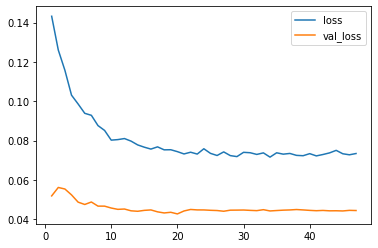

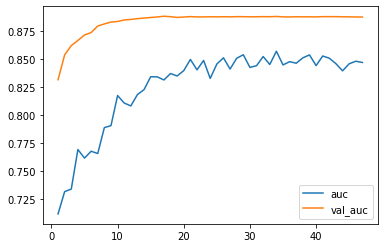

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['auc', 'val_auc']].plot()

In [31]:
preds_eval = []
for model in models:
    preds_eval.append(model.predict(X))
    
print(classification_report(y, np.round(np.average(np.array(preds_eval),axis=0))))

              precision    recall  f1-score   support

         0.0       1.00      0.58      0.73     14672
         1.0       0.12      0.96      0.22       881

    accuracy                           0.60     15553
   macro avg       0.56      0.77      0.47     15553
weighted avg       0.95      0.60      0.70     15553



In [ ]:
pred = np.average(np.array(preds),axis=0)
pred

In [ ]:
submission['stroke'] = pred
submission['stroke'] = submission['stroke'].clip(0,1)
submission

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.stroke.hist()